* https://uniswapv3book.com/index.html
* https://medium.com/@chaisomsri96/defi-math-uniswap-v3-concentrated-liquidity-bd87686b3ecf
* https://liobaheimbach.github.io/assets/pdf/Papers/Risks_and_Returns_of_Uniswap_V3_Liquidity_Providers.pdf
* https://docs.uniswap.org/sdk/v3/guides/advanced/active-liquidity
* https://blog.uniswap.org/uniswap-v3-math-primer
* https://blog.uniswap.org/uniswap-v3-math-primer-2
* https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf

In [1]:
from uniswappy import *
import pandas as pd
import copy
import matplotlib.pyplot as plt

user_nm = MockAddress().apply()
eth_amount = 10000
tkn_amount = 100000

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

In [2]:
n_steps = 100
start_price = eth_amount/tkn_amount
mu = 0.1; sigma = 0.5
n_paths = 1

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

accounts = MockAddress().apply(250)

Text(0.5, 0, 'Date')

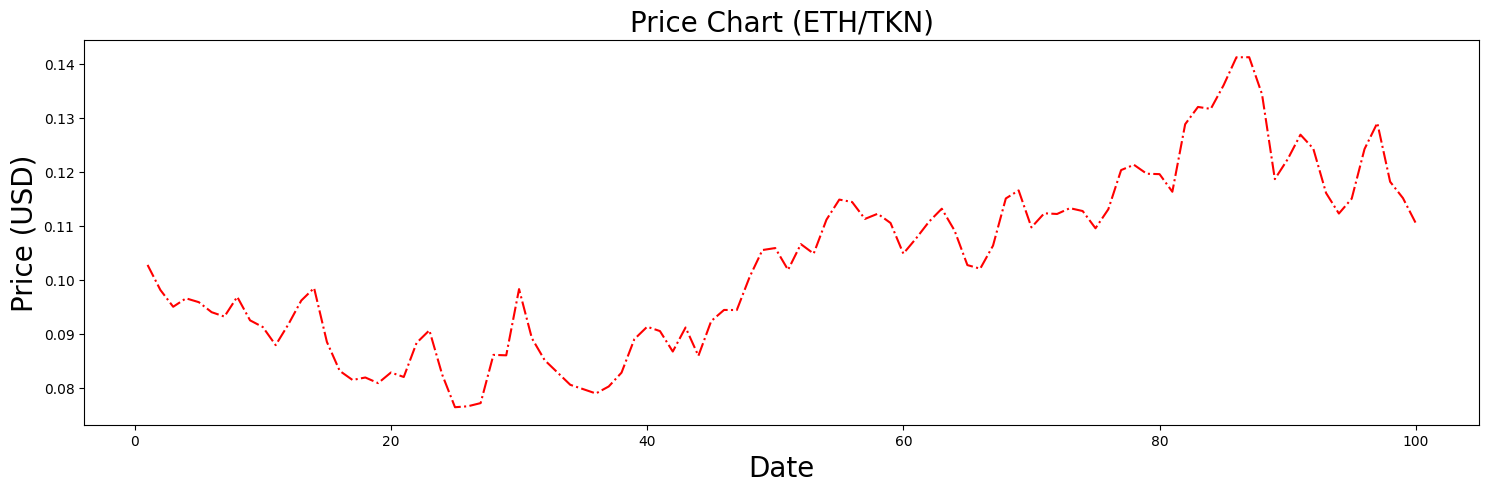

In [3]:
x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(x_val[1:], p_arr[1:], color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart (ETH/TKN)', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

In [4]:
tkn = ERC20("TKN", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

Join().apply(lp, user_nm, eth_amount, tkn_amount)
lp.summary()

Exchange ETH-TKN (LP)
Reserves: ETH = 10000, TKN = 100000
Liquidity: 31622.776601683792 



In [5]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()

    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)

    # Random trade volume  
    if(select_tkn == 0):
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt)
        out = Swap().apply(lp, eth, user_nm, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt)
        out = Swap().apply(lp, tkn, user_nm,  p*rnd_swap_amt)  
    
    print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()

Market: 0.10281455317925865, LP: 0.10270530170852728
Market: 0.09817823360271385, LP: 0.09831157873414532
Market: 0.0950674272834637, LP: 0.09510105611171309
Market: 0.09662902989674803, LP: 0.09658413056354372
Market: 0.09591791112985851, LP: 0.09611038592994044
Market: 0.0940640277969813, LP: 0.09402757745764989
Market: 0.09324677659742302, LP: 0.09329895432194488
Market: 0.09690981782742153, LP: 0.0968134116549733
Market: 0.09255550183870641, LP: 0.092528584194007
Market: 0.09130449144006059, LP: 0.09199959165270451
Market: 0.08796211174727553, LP: 0.08790712508173373
Market: 0.09183980732013235, LP: 0.0917328778511602
Market: 0.09622086269920718, LP: 0.09624132128036555
Market: 0.09853816659238737, LP: 0.09862915832136686
Market: 0.08855327835907714, LP: 0.08850337425062153
Market: 0.0831912643307069, LP: 0.08284153791067418
Market: 0.08150827384956584, LP: 0.08160723808534655
Market: 0.08196591111507238, LP: 0.0819329719635319
Market: 0.08092441484893739, LP: 0.08062398073661381
M

In [6]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

#lwr_tick = lp.get_tick_price(-1, 10, 5000)
#upr_tick = lp.get_tick_price(1, 10, 5000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

SwapDeposit().apply(lp,  eth,  user_nm, 100, lwr_tick, upr_tick)
lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 100000.0
Gross Liquidity: 31622.776601683792 

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 10100.000000017026, TKN = 100000.0
Gross Liquidity: 31780.261401158732 



In [7]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Helper().get_tick_price(lp, -1, 10, 1000)
upr_tick = UniV3Helper().get_tick_price(lp, 1, 10, 1000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9670.469739529013, TKN = 100000.0
Gross Liquidity: 644033.2066424165 



In [8]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p, lwr_tick, upr_tick)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()
    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)

    lwr_tick = UniV3Helper().get_tick_price(lp, -1, lp.get_price(eth), 1000)
    upr_tick = UniV3Helper().get_tick_price(lp, 1, lp.get_price(eth), 1000)
    
    if(select_tkn == 0): 
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt, lwr_tick, upr_tick)
        out = Swap().apply(lp, eth, user_swap, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt, lwr_tick, upr_tick)
        out = Swap().apply(lp, tkn, user_swap,  p*rnd_swap_amt) 

    print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()

Market: 0.10281455317925865, LP: 0.10280550228418321
Market: 0.09817823360271385, LP: 0.09821117746645226
Market: 0.0950674272834637, LP: 0.09507091702775197
Market: 0.09662902989674803, LP: 0.09662415747628318
Market: 0.09591791112985851, LP: 0.09591631812435397
Market: 0.0940640277969813, LP: 0.09406465018701386
Market: 0.09324677659742302, LP: 0.09324901137104068
Market: 0.09690981782742153, LP: 0.09689305712917202
Market: 0.09255550183870641, LP: 0.09259882333917964
Market: 0.09130449144006059, LP: 0.09130240666349476
Market: 0.08796211174727553, LP: 0.0881852003830092
Market: 0.09183980732013235, LP: 0.0913705150515728
Market: 0.09622086269920718, LP: 0.09618838389595119
Market: 0.09853816659238737, LP: 0.09853996011152982
Market: 0.08855327835907714, LP: 0.08453146539553479
Market: 0.0831912643307069, LP: 0.08319962311182921
Market: 0.08150827384956584, LP: 0.0815053569425273
Market: 0.08196591111507238, LP: 0.08250329266524845
Market: 0.08092441484893739, LP: 0.08070719448368803

In [9]:
lp.ticks

{22020: TickInfo(liquidityGross=689761025979275808960000, liquidityNet=600325495330632511040000, feeGrowthOutside0X128=335801474113184913488978224684542791, feeGrowthOutside1X128=4833275110030348179258825454855852802),
 24000: TickInfo(liquidityGross=703789116604585917100000, liquidityNet=-586297404705322402900000, feeGrowthOutside0X128=225810458477660466458482839545683917, feeGrowthOutside1X128=3893632975270308004816894442975379669),
 21720: TickInfo(liquidityGross=4959403480187723500000, liquidityNet=4959403480187723500000, feeGrowthOutside0X128=361869265442704169591365643453324400, feeGrowthOutside1X128=5059914781070235451138266709493248449),
 23760: TickInfo(liquidityGross=3390703451419856800000, liquidityNet=-3390703451419856800000, feeGrowthOutside0X128=238428786664037854664509929499194312, feeGrowthOutside1X128=4031196118975279520375366667300817261),
 22200: TickInfo(liquidityGross=93849126464475478000000, liquidityNet=91697632376691376400000, feeGrowthOutside0X128=3198711923122